In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal as signal

In [4]:
dt = 1/24
t = np.arange(0,100+dt,dt)

In [48]:
a1,a2,omega1,omega2 = 0.5,0.5,1.93,2
x = a1*np.exp(1j*2*np.pi*omega1*t)+a2*np.exp(1j*2*np.pi*omega2*t)
xh = signal.hilbert(x.real)
ds = xr.Dataset({'signal':(['time'],x.real),'hilbert':(['time'],xh)},coords={'time':t})

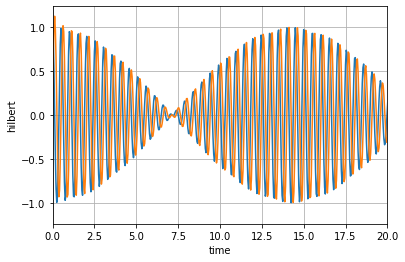

In [51]:
#ds['signal'].real.plot(xlim=(0,20));
ds['hilbert'].real.plot(xlim=(0,20));
ds['hilbert'].imag.plot(xlim=(0,20));
plt.grid();

In [54]:
ds['demodulated'] = ds['hilbert']*np.exp(-1j*2*np.pi*(omega1+omega2)/2*t)

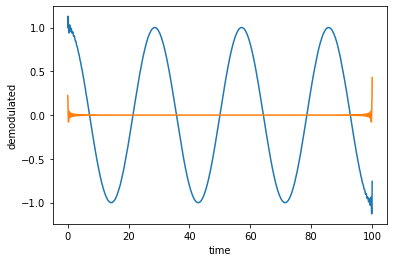

In [57]:
ds.demodulated.real.plot()
ds.demodulated.imag.plot()

In [65]:
def ha(a1,a2):
    omega1,omega2 = 1.93,2
    x = a1*np.exp(1j*2*np.pi*omega1*t)+a2*np.exp(1j*2*np.pi*omega2*t)
    xh = signal.hilbert(x.real)
    ds = xr.Dataset({'signal':(['time'],x.real),'hilbert':(['time'],xh)},coords={'time':t})
    ds['demodulated'] = ds['hilbert']*np.exp(-1j*2*np.pi*(omega1+omega2)/2*t)
    return ds

In [68]:
_ds = xr.concat([ha(a1,a_2) for a_2 in [0,0.1,1]], dim='a2').assign_coords({'a2':[0,0.1,1]})

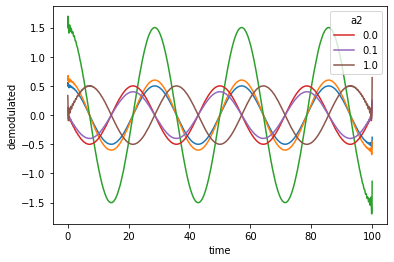

In [71]:
_ds.demodulated.real.plot(hue='a2')
_ds.demodulated.imag.plot(hue='a2')

In [79]:

print(np.cos(np.pi/4),np.sin(np.pi/4))

0.7071067811865476 0.7071067811865475


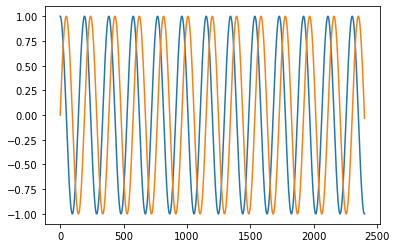

In [81]:
plt.plot(np.cos(np.pi/4*t))
plt.plot(np.sin(np.pi/4*t))

In [106]:
a1,a2 = 10.,0.5
A = (a1+a2)*(a1-a2)
om = (omega1+omega2)/2
time = t[:int(20/dt)]

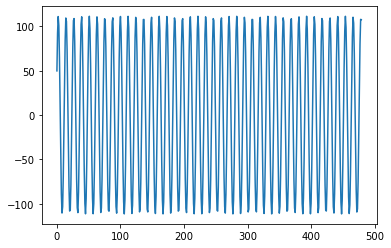

In [107]:
plt.plot(A*(0.5*np.cos(2*np.pi*om*time)+np.sin(2*np.pi*om*time)))